In [3]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

In [8]:
# Load the data
df_processed = pd.read_csv('AAPL_Processed_Data.csv', index_col='Date', parse_dates=True)

# show coloumns
print("Columns in the dataset:")
print(df_processed.columns)

Columns in the dataset:
Index(['Close_AAPL', 'High_AAPL', 'Low_AAPL', 'Open_AAPL', 'Volume_AAPL',
       'Target', 'Prev_Close', 'SMA_10', 'Daily_Return'],
      dtype='object')


In [9]:
features = ['Prev_Close', 'SMA_10', 'Daily_Return']

# Define X (features) and y (target)
X = df_processed[features]
y = df_processed['Target']

# **CRUCIAL for Time Series: Chronological Split**
# DO NOT SHUFFLE!
split_point = int(len(X) * 0.8) # 80% for training, 20% for testing

X_train, X_test = X[:split_point], X[split_point:]
y_train, y_test = y[:split_point], y[split_point:]

# Also get the actual closing prices for the test period for backtesting
# Ensure this 'Close' column corresponds to the same index as X_test
test_close_prices = df_processed['Close_AAPL'][split_point:]

print(f"Training set size: {len(X_train)} samples")
print(f"Testing set size: {len(X_test)} samples")

Training set size: 998 samples
Testing set size: 250 samples


In [10]:
# Train the model
model = LogisticRegression(random_state=42, solver='liblinear') # liblinear is good for small datasets
model.fit(X_train, y_train)

# Make predictions on the test set
predictions = model.predict(X_test)
prediction_probabilities = model.predict_proba(X_test)[:, 1] # Probability of target being 1 (price up)

In [11]:
# Evaluate the model
print("\n--- Model Evaluation (Logistic Regression) ---")
print(f"Accuracy: {accuracy_score(y_test, predictions):.4f}")
print("\nClassification Report:")
print(classification_report(y_test, predictions))


--- Model Evaluation (Logistic Regression) ---
Accuracy: 0.4560

Classification Report:
              precision    recall  f1-score   support

           0       0.42      0.67      0.51       108
           1       0.54      0.30      0.38       142

    accuracy                           0.46       250
   macro avg       0.48      0.48      0.45       250
weighted avg       0.49      0.46      0.44       250



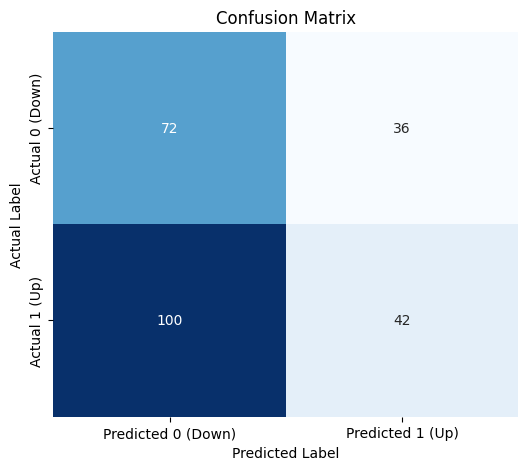

In [12]:
# Confusion Matrix
cm = confusion_matrix(y_test, predictions)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Predicted 0 (Down)', 'Predicted 1 (Up)'],
            yticklabels=['Actual 0 (Down)', 'Actual 1 (Up)'])
plt.title('Confusion Matrix')
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.show()

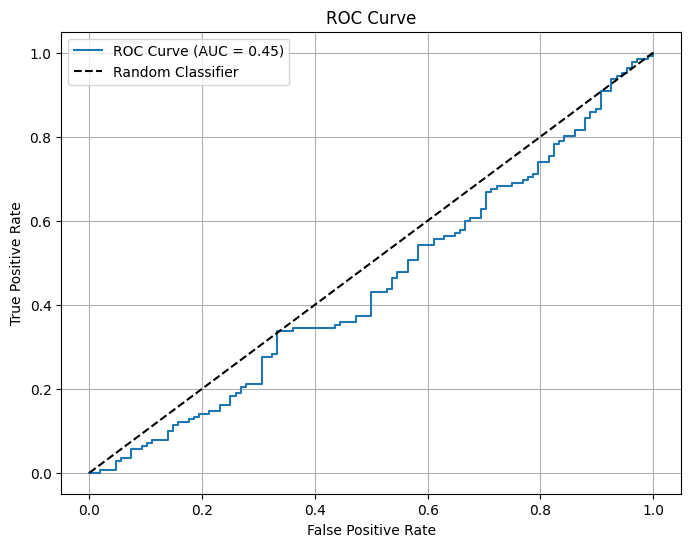

AUC Score: 0.4467


In [13]:
# ROC Curve and AUC
fpr, tpr, thresholds = roc_curve(y_test, prediction_probabilities)
auc = roc_auc_score(y_test, prediction_probabilities)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.grid(True)
plt.show()

print(f"AUC Score: {auc:.4f}")

Understanding Model Evaluation:

Accuracy: Overall correct predictions.

Precision (for class 1): Of all times the model predicted "Up" (1), how many were actually "Up"? Important for minimizing false positives (buying when price doesn't go up).

Recall (for class 1): Of all times the price actually went "Up" (1), how many did the model correctly identify? Important for not missing opportunities.

F1-score: Harmonic mean of precision and recall.

Confusion Matrix: Shows true positives, true negatives, false positives, false negatives.

ROC Curve & AUC: Measures the model's ability to distinguish between classes across various thresholds. An AUC of 0.5 is random, 1.0 is perfect. Given your low correlation, expect AUC to be close to 0.5.


--- Backtesting Results (Simplified) ---
Initial Capital: $10000.00
Final Portfolio Value: $12140.32
Total Return: 21.40%
Buy and Hold Final Value: $13754.98
Buy and Hold Total Return: 37.55%


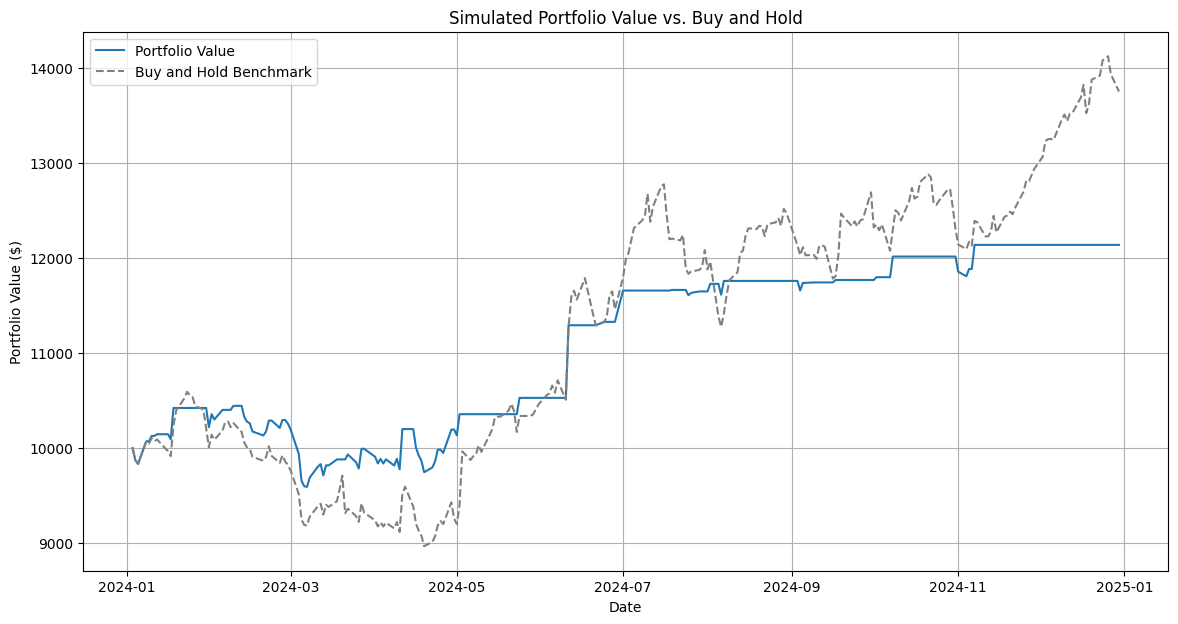


--- Summary of Trades ---
{'Date': Timestamp('2024-01-03 00:00:00'), 'Action': 'BUY', 'Price': np.float64(182.91049194335932), 'Shares': np.float64(54.67154942154239)}
{'Date': Timestamp('2024-01-08 00:00:00'), 'Action': 'SELL', 'Price': np.float64(184.2109832763672), 'Shares': 0}
{'Date': Timestamp('2024-01-09 00:00:00'), 'Action': 'BUY', 'Price': np.float64(183.79405212402344), 'Shares': np.float64(54.795570149293475)}
{'Date': Timestamp('2024-01-10 00:00:00'), 'Action': 'SELL', 'Price': np.float64(184.8364105224609), 'Shares': 0}
{'Date': Timestamp('2024-01-11 00:00:00'), 'Action': 'BUY', 'Price': np.float64(184.24078369140625), 'Shares': np.float64(54.972717201916325)}
{'Date': Timestamp('2024-01-12 00:00:00'), 'Action': 'SELL', 'Price': np.float64(184.56837463378903), 'Shares': 0}
{'Date': Timestamp('2024-01-16 00:00:00'), 'Action': 'BUY', 'Price': np.float64(182.2950439453125), 'Shares': np.float64(55.65826060638512)}
{'Date': Timestamp('2024-01-18 00:00:00'), 'Action': 'SELL', 

In [15]:
# Create a DataFrame for backtesting results
backtest_df = pd.DataFrame(index=X_test.index)
backtest_df['Actual_Close'] = test_close_prices
backtest_df['Predicted_Direction'] = predictions
backtest_df['Actual_Direction'] = y_test

# --- Simple Trading Strategy ---
# Start with some capital
initial_capital = 10000.0
capital = initial_capital
shares_held = 0
portfolio_values = [] # Track portfolio value over time
trades = [] # Store trade details

# Assume we can buy/sell at the 'Actual_Close' price of the day
# and we always buy/sell a fixed amount (e.g., $1000 worth or 10 shares) for simplicity

# Iterate through the test period
for i in range(len(backtest_df)):
    current_date = backtest_df.index[i]
    current_price = backtest_df['Actual_Close'].iloc[i]
    predicted_direction = backtest_df['Predicted_Direction'].iloc[i]
    # actual_direction = backtest_df['Actual_Direction'].iloc[i] # For analysis, not for decision making

    # Decide on action based on prediction
    action = 'HOLD' # Default action

    if predicted_direction == 1: # Model predicts price will go up
        if shares_held == 0 and capital > 0:
            # Buy if we have cash and no shares
            shares_to_buy = capital / current_price # Buy as many shares as possible
            shares_held += shares_to_buy
            capital = 0 # All cash spent
            action = 'BUY'
            trades.append({'Date': current_date, 'Action': action, 'Price': current_price, 'Shares': shares_to_buy})
    elif predicted_direction == 0: # Model predicts price will go down
        if shares_held > 0:
            # Sell if we hold shares
            capital += shares_held * current_price # Convert shares back to cash
            shares_held = 0
            action = 'SELL'
            trades.append({'Date': current_date, 'Action': action, 'Price': current_price, 'Shares': 0}) # Shares=0 indicates selling all

    # Calculate current portfolio value
    current_portfolio_value = capital + (shares_held * current_price)
    portfolio_values.append(current_portfolio_value)

# Append final value if still holding shares at the end
if shares_held > 0:
    final_price = backtest_df['Actual_Close'].iloc[-1]
    final_portfolio_value = capital + (shares_held * final_price)
    portfolio_values[-1] = final_portfolio_value # Update last recorded value

# Print backtesting results for model  
print("\n--- Backtesting Results (Simplified) ---")
print(f"Initial Capital: ${initial_capital:.2f}")
print(f"Final Portfolio Value: ${portfolio_values[-1]:.2f}")
print(f"Total Return: {((portfolio_values[-1] - initial_capital) / initial_capital * 100):.2f}%")

# Print backtesting results for buy and hold strategy
buy_and_hold_value = (initial_capital / backtest_df['Actual_Close'].iloc[0]) * backtest_df['Actual_Close']
buy_and_hold_return = ((buy_and_hold_value.iloc[-1] - initial_capital) / initial_capital * 100)
print(f"Buy and Hold Final Value: ${buy_and_hold_value.iloc[-1]:.2f}")
print(f"Buy and Hold Total Return: {buy_and_hold_return:.2f}%")

# Visualize Portfolio Value
plt.figure(figsize=(14, 7))
plt.plot(backtest_df.index, portfolio_values, label='Portfolio Value')
# Plot a simple 'Buy and Hold' benchmark for comparison
plt.plot(backtest_df.index, buy_and_hold_value, label='Buy and Hold Benchmark', linestyle='--', color='gray')
plt.title('Simulated Portfolio Value vs. Buy and Hold')
plt.xlabel('Date')
plt.ylabel('Portfolio Value ($)')
plt.grid(True)
plt.legend()
plt.show()

print("\n--- Summary of Trades ---")
for trade in trades[:10]: # Print first 10 trades as example
    print(trade)

Key Improvements for Backtesting (Future Steps):

More Realistic Trading Logic:

Fixed Share/Capital Size: Instead of buying all available capital, buy a fixed number of shares or a fixed dollar amount.

Transaction Costs/Slippage: Account for commissions and the difference between your desired price and the actual execution price.

Entry/Exit Signals: Define clearer rules for when to buy/sell (e.g., buy at next day's open if predicted up, sell at next day's open if predicted down).

Performance Metrics: Calculate financial metrics like:

Sharpe Ratio: Risk-adjusted return.

Max Drawdown: Largest peak-to-trough decline.

Sortino Ratio: Similar to Sharpe, but only considers downside risk.

Annualized Return.

Benchmark Comparison: Always compare your strategy's performance against a simple "buy and hold" strategy.

Visualization: Plot trades on the price chart to see where your model bought/sold.